<a href="https://colab.research.google.com/github/janerikhy/BEM/blob/main/BEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Set directory paths for data files. 

# When using Google Colab: 
base_dir = os.path.abspath('')
drive_dir = os.path.join(base_dir, 'drive', 'MyDrive')
data_dir = os.path.join(drive_dir, 'BEM')

# When using local relative paths
"""
base_dir = os.path.dirname(__file__)
data_dir = os.path.join(BASE_DIR, 'data')
"""

profiles = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

PROFILES = {}

BLADE = pd.read_csv(os.path.join(data_dir, 'bladedat.txt'),
                    sep="\t", header=None)
BLADE.columns = ['r', 'beta', 'c', 't/c']


for file in profiles:
  profile_type = file.split('/')[-1].split('.')[0]
  df = pd.read_csv(file, header=None)
  df.columns = ['alpha', 'Cl', 'Cd', 'Cm']
  PROFILES[int(profile_type)] = df

def foil_interp(t: float, a: float) -> tuple:
    """
    foil_interp takes the thickness and angle of attack
    to calculate the lift and drag coeffs. 

    Args:
        t (float): thickness of the foil section
        a (float): angle of attack in degrees
    Returns:
        tuple: (Cl, Cd)
    """
    prof_t = [thick/10 for thick in PROFILES.keys()]
    # If we have complete data, we simply interpolate once
    if t in prof_t:
        t = int(t*10)
        Cl = np.interp(a, PROFILES[t]['alpha'], PROFILES[t]['Cl'])
        Cd = np.interp(a, PROFILES[t]['alpha'], PROFILES[t]['Cd'])
        return (Cl, Cd)

    # If thickness is not equal to a profile, double interpolation necessary
    prof_t = ([int(i*10) for i in prof_t])
    t = t*10
    prof_t.append(t)
    prof_t = sorted(prof_t)

    x_l = prof_t[prof_t.index(t) - 1]
    x_u = prof_t[prof_t.index(t) + 1]

    cl_1 = np.interp(a, PROFILES[x_l]['alpha'], PROFILES[x_l]['Cl'])
    cl_2 = np.interp(a, PROFILES[x_u]['alpha'], PROFILES[x_u]['Cl'])

    cd_1 = np.interp(a, PROFILES[x_l]['alpha'], PROFILES[x_l]['Cd'])
    cd_2 = np.interp(a, PROFILES[x_u]['alpha'], PROFILES[x_u]['Cd'])

    Cl = np.interp(t, [prof_t[prof_t.index(x_l)],
                   prof_t[prof_t.index(x_u)]], [cl_1, cl_2])
    Cd = np.interp(t, [prof_t[prof_t.index(x_l)],
                   prof_t[prof_t.index(x_u)]], [cd_1, cd_2])

    return (Cl, Cd)


In [ ]:
# Set the constants
R = 89.17
B = 3
radius = [r for r in BLADE['r']]
rho = 1.255
V0 = 9.5
# speed_ratio = np.arange(5, 11, 1)
omega_min = 6*np.pi*2/60
omega_max = 9.6*2*np.pi/60+0.02

omega = np.arange(omega_min, omega_max, 0.01)
speed_ratio = np.array([o*R/V0 for o in omega])

min_pitch = -4
max_pitch = 7
pitch = np.arange(min_pitch, max_pitch, 0.1)


P = np.zeros((len(speed_ratio), len(pitch)))
T = np.zeros((len(speed_ratio), len(pitch)))

# Factor for under relaxation
beta = 0.1

# Requirement for iteration loop
eps = 5e-5

for i in range(len(speed_ratio)):
  print(f"Percentage done: {i/len(speed_ratio)*100:.2f}%")
  for j in range(len(pitch)):
    pt = np.zeros((len(radius)))
    pn = np.zeros((len(radius)))

    for k in range(len(radius)):
      if radius[k]/R > 0.98:
          pt[k] = 0
          pn[k] = 0
          break
      counter = 0
      max_count = 1000
      a = 0
      ap = 0
      a_old = 0
      ap_old = 0
      diff_a = 1
      diff_ap = 1

      while (abs(diff_a) > eps) or (abs(diff_ap) > eps) and (counter < max_count):
        # Phi in radians
        phi = np.arctan2((1-a_old)*R, ((1+ap_old)*speed_ratio[i]*radius[k]))
        # Theta in degrees
        theta = BLADE['beta'][k] + pitch[j]

        # Alpha in degrees
        alpha = np.rad2deg(phi) - theta

        t = BLADE['t/c'][k]

        # Prandtl correction factor
        F = 2/np.pi * np.arccos(np.exp(-B/2*(R-radius[k])/(radius[k]*np.sin(abs(phi)))))
            
        # Interpolate to find Cl and Cd
        (Cl, Cd) = foil_interp(t, alpha)

        # Calculate normal and tangential load coeffs
        Cn = Cl*np.cos(phi) + Cd*np.sin(phi)
        Ct = Cl*np.sin(phi) - Cd*np.cos(phi)

        # Solidity for calculation
        sigma = BLADE['c'][k]*B/(2*np.pi*radius[k])

        # Thrust coeff
        C_T = (1-a_old)**2*Cn*sigma/(np.sin(phi)**2)

        if a_old < 1/3:
            # Update a without Glauert correction
            a = 1/(4*F*np.sin(phi)**2/(sigma*Cn) + 1)
        else:
            # Using Gluaert correction with under relaxation
            _a = C_T/(4*F*(1 - 1/4 * (5 - 3*a_old)*a_old))
            a = beta*_a + (1-beta)*a_old

        # Update a'
        ap = 1 / (4*np.sin(phi)*np.cos(phi)/(sigma*Ct) - 1)

        # Calculate difference to check for convergence
        diff_a = a - a_old
        diff_ap = ap - ap_old
        counter += 1
        a_old = a
        ap_old = ap

      # Calculate the relative wind speed
      U = (1-a)*V0
      U_t = (1 + ap)*omega[i]*radius[k]
      V_rel = np.sqrt(U**2 + U_t**2)

      Pt = 1/2*rho*V_rel**2*BLADE['c'][k]*Ct
      Pn = 1/2*rho*V_rel**2*BLADE['c'][k]*Cn

      pt[k] = Pt
      pn[k] = Pn
  

    # Here we can calculate the total loads for each ratio and pitch
    P[i][j] = omega[i]*B*np.trapz(radius*pt, radius)
    T[i][j] = B*np.trapz(pn, radius)

print("Completed!")


CP = P/(1/2*rho*V0**3*np.pi*R**2)
CT = T/(1/2*rho*V0**2*np.pi*R**2)

X, Y = np.meshgrid(pitch, speed_ratio)



Percentage done: 0.00%
Percentage done: 2.50%
Percentage done: 5.00%
Percentage done: 7.50%
Percentage done: 10.00%
Percentage done: 12.50%
Percentage done: 15.00%
Percentage done: 17.50%
Percentage done: 20.00%
Percentage done: 22.50%
Percentage done: 25.00%
Percentage done: 27.50%
Percentage done: 30.00%
Percentage done: 32.50%
Percentage done: 35.00%
Percentage done: 37.50%
Percentage done: 40.00%
Percentage done: 42.50%
Percentage done: 45.00%
Percentage done: 47.50%
Percentage done: 50.00%
Percentage done: 52.50%
Percentage done: 55.00%
Percentage done: 57.50%
Percentage done: 60.00%
Percentage done: 62.50%
Percentage done: 65.00%
Percentage done: 67.50%
Percentage done: 70.00%
Percentage done: 72.50%
Percentage done: 75.00%
Percentage done: 77.50%
Percentage done: 80.00%
Percentage done: 82.50%
Percentage done: 85.00%
Percentage done: 87.50%
Percentage done: 90.00%
Percentage done: 92.50%
Percentage done: 95.00%
Percentage done: 97.50%
Completed!


In [ ]:
P

array([[5719050.61881483, 5791287.52571827, 5815632.19558378,
        5777291.74055813, 5700110.51376722, 5567676.46920871,
        5410450.0498519 , 5219486.20965473, 4995418.46200378,
        4749814.6971845 , 4473611.60413579],
       [6026716.56108779, 6082606.97596914, 6099771.52860432,
        6077409.65925072, 6041903.70489864, 5954201.58912817,
        5809338.0367463 , 5625817.0471452 , 5373202.76298998,
        5065904.7632746 , 4706577.09878448],
       [5719213.73420251, 5925104.3917835 , 6077968.48264773,
        6187144.23852898, 6205888.03025941, 6166138.98408519,
        6063032.1461356 , 5863271.34754367, 5575092.27363154,
        5203625.17820651, 4749938.59876315],
       [5123977.45391754, 5493044.98583197, 5792850.23705301,
        6010294.50328219, 6132647.57274673, 6156869.6244837 ,
        6086579.8483967 , 5916139.66429223, 5607836.8528383 ,
        5173859.61734746, 4623652.67519566]])

<a list of 31 text.Text objects>

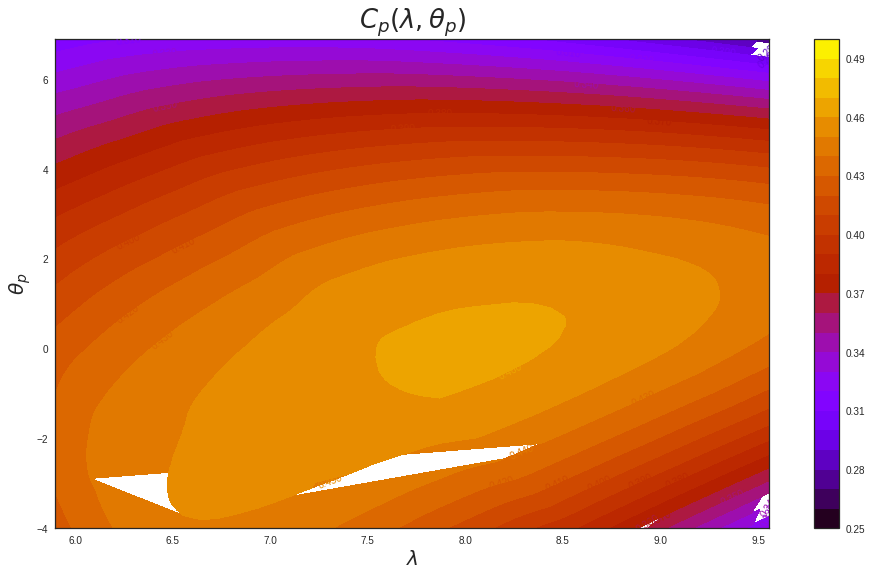

In [ ]:
from datetime import datetime

now = datetime.now()

dt_string = now.strftime("%d%m%Y_%H:%M:%S")

plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(16, 9))
levels = np.arange(0.25, 0.510, 0.01)
CS = ax.contourf(Y, X, CP, levels, cmap="gnuplot")
fig.colorbar(CS)
ax.set_xlabel(r'$\lambda$', fontsize=20)
ax.set_ylabel(r"$\theta_p$", fontsize=20)
ax.set_title(r"$C_p(\lambda, \theta_p)$", fontsize=26)
ax.clabel(CS, inline=True, fontsize=10)
# plt.savefig(os.path.join(data_dir, f'cp_contour_{dt_string}.png'), dpi=300)

<a list of 21 text.Text objects>

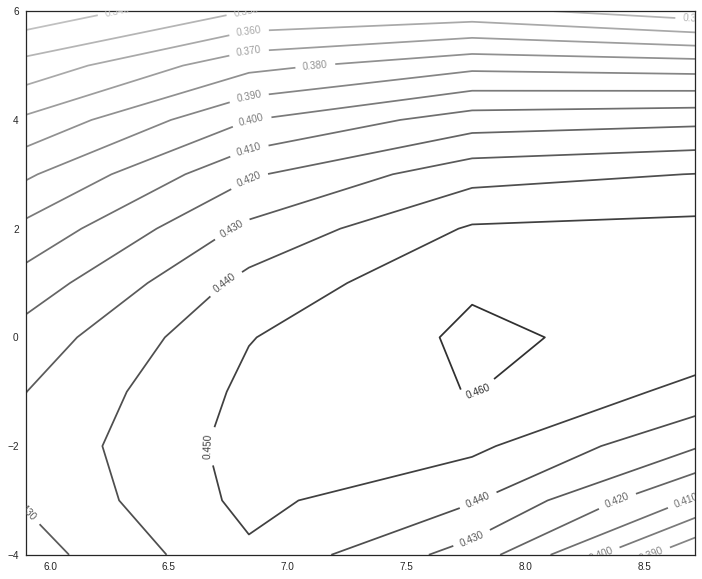

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
CS = ax.contour(Y, X, CP, levels)
ax.clabel(CS, inline=True, fontsize=10)

**Testing of the interpolation function**

To make sure that the function for double interpolation works, this section will perfom an interpolation in stages and check how the functions corresponds to this result. 


In [ ]:
# Want to test the interpolation 

t1 = BLADE['t/c'][1] # Checking with a thickness - cord length ratio of 86.049 (at the second radius)

# Setting arbitrary angle of attack to 4 deg
alpha = 4

# Find the lift coefficient for the closest foils (1000 & 600)
cl_1000 = np.interp(alpha, PROFILES[1000]['alpha'], PROFILES[1000]['Cl'])

cl_600 = np.interp(alpha, PROFILES[600]['alpha'], PROFILES[600]['Cl'])


# Try interpolating between the two of them
cl_860 = np.interp(t1, [60, 100], [cl_600, cl_1000])
cl_860

cl_from_func = foil_interp(t1, alpha)

# Result from the two processes: 
print("Difference between manual double interpolation and function: {:.17f}".format(cl_860-cl_from_func[0]))

Difference between manual double interpolation and function: 0.00000000000000006


**Question 2**

Tip speed limited to $90$ $[\frac{m}{s}]$.

$\omega_{max}$ = 1.01 $[\frac{rad}{s}]$, which is the same as $\approx$ 9.6 $RPM$ that was set at maximum rotational speed in the report. 

What would be the maximum wind where the turbine can run   at its maximum efficiency $C_{P,opt}(λ_{opt},θ_{p, opt})$ and what would be the power.  Plot ω(Vo). 

\begin{equation}
\lambda = \frac{\omega R}{V_0}
\end{equation}

We could probably iterate over the different speed ratios to find the combination of speed ratio and pitch angle that gives the largest $C_P$ in general. 

\begin{equation}
P = T\omega
\end{equation}

*Keep in mind that the cut of wind speed in the report is said to be 25 $[\frac{m}{s}]$.*




In [ ]:
lam_opt, theta_opt = 0, 0
lam_index, theta_index = None, None
max_cp = 0

for i in range(len(speed_ratio)):
  max_val = max(CP[i])
  if max_val > max_cp:
    max_cp = max_val
    lam_index = i
    theta_index = np.argmax(CP[i])
    theta_opt = pitch[theta_index]
    lam_opt = speed_ratio[i]

print(f"Optimal pitch = {theta_opt} [rad/s]")
print(f"Optimal tip speed ratio: {lam_opt}")
print(f"Max Cp: {max_cp:.4f}")

Optimal pitch = -0.09999999999999654 [rad/s]
Optimal tip speed ratio: 7.962585619381094
Max Cp: 0.4622


From the calculations we find that:



*   $\lambda_{opt}$ = 7.96 $\approx$ 8 
*   $\theta_{p, opt}$ = -0.099 $\approx$ -0.1



Text(0, 0.5, '$V_0$')

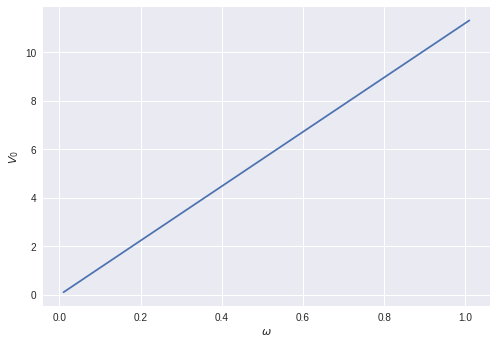

In [ ]:
# We want to plot V_0 (incomming wind speed) as a function of the rotational speed where it can maintan top power output

def V(w: float) -> float:
  """
  Calculate the necessary wind speed to have Cp_opt

  Constants:
    lambda = 7.96
    ptich angle = -0.1
    w_max = 1.01

  Vairables:
    w[float]: The rotational speed
  """

  l = 7.96
  v = w*R/l

  return v

rot_speed = np.arange(0.01, 1.02, 0.01)

plt.plot(rot_speed, V(rot_speed))
plt.xlabel(r"$\omega$")
plt.ylabel(r"$V_0$")
plt.show()

In [ ]:
v_max = max([V(w) for w in rot_speed])
print(f"Maximum incomming wind speed: {v_max:.4f}")

Maximum incomming wind speed: 11.3143


From the calculations we can observe that the maximum incomming wind speed will be:

\begin{equation}
V_0 = 11.31 [\frac{m}{s}]
\end{equation}

This is much lower that the cut off wind speed of 25 $[\frac{m}{s}]$. This can perhaps be an indication that when the wind speed gets very large, we will no longer be able to extract as much of the incomming wind energy. Thus, we will have to change the pitch angle when the wind exceeds 11.3 $[\frac{m}{s}]$.

In [ ]:
# At wind of v_max we would be able to extract:

P = CT[lam_index][theta_index]*1/2*rho*11.31**2*np.pi*R**2*1.01

1.6847295850265156